In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle

from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 10000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "cuda:0" if torch.cuda.is_available() else "cpu"

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0

        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)


    def forward(self, x):
        return self.linear(x)


/Users/zephyr/anaconda3/envs/modmi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



In [ ]:

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)

def accuracy(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    correct = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        #print(x.shape)
        logits = network(x.to(device))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(device))
        total += x.size(0)
    return correct / total

def loss_f(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        logits = network(x.to(device))
        loss += torch.sum((logits-torch.eye(10,)[labels].to(device))**2)
        total += x.size(0)
    return loss / total

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

def L2(model):
    L2_ = 0.
    for p in mlp.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in mlp.parameters():
        p.data = alpha * p.data


width = 200
mlp = BioMLP2D(shp=(784,100,100,10))
mlp.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)

one_hots = torch.eye(10, 10).to(device)

mlp.eval()
print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device)))

test_accuracies = []
train_accuracies = []

step = 0
mlp.train()
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.

log = 200
# lamb = 0.01
# swap_log = 500
plot_log = 500


train_type = 1; #no L1
# train_type = 2; #L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
lamb = 0 if train_type==1 else 0.01
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 2. if train_type == 3 or train_type == 5 else 0.

for x, label in pbar:

    if step == int(steps/4):
        lamb *= 10
    elif step == int(steps/2):
        lamb *= 10

    mlp.train()
    optimizer.zero_grad()
    loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
    cc = mlp.get_cc(weight_factor, no_penalize_last=True)
    total_loss = loss_train + lamb*cc
    total_loss.backward()
    optimizer.step()

    if step % log == 0:
        with torch.no_grad():
            mlp.eval()
            train_acc = accuracy(mlp, train, device).item()
            test_acc = accuracy(mlp, test, device).item()
            train_loss = loss_f(mlp, train, device).item()
            test_loss = loss_f(mlp, test, device).item()

            if train_acc > best_train_acc:
                best_train_acc = train_acc
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            if train_loss < best_train_loss:
                best_train_loss = train_loss
            if test_loss < best_test_loss:
                best_test_loss = test_loss
            mlp.train()
            pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} ".format(train_acc, test_acc, train_loss, test_loss, cc))
    step += 1

    if step % swap_log == 0:
        mlp.relocate()

    if (step-1) % plot_log == 0:

        fig=plt.figure(figsize=(30,15))
        ax=fig.add_subplot(projection='3d')

        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
        ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
        ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
        ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
        ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
        ax.set_zlim(-0.5,5)
        ax.set_xlim(-0.2,1.2)
        ax.set_ylim(-0.2,1.2)


        for ii in range(3):
            biolinear = mlp.linears[ii]
            p = biolinear.linear.weight.clone()
            p_shp = p.shape
            p = p/torch.abs(p).max()

            for i in range(p_shp[0]):
                if i % 20 == 0:
                    print(i)
                for j in range(p_shp[1]):
                    out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
                    in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
                    plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


        ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
        for i in range(10):
            ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


        ax.view_init(30,10)

        ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

        ax.axis('off')

        plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

        plt.show()


In [144]:
torch.save(mlp.state_dict(), 'mnist_no_nothing.pt')


# Activation Patching

## Clean and Corrupted Inputs

In [248]:
og_img = train[46][0][0].detach().numpy()
gaussian = np.random.normal(0, 10**0.5, (og_img.shape[0],og_img.shape[1])) 
corrupted_img = og_img + gaussian

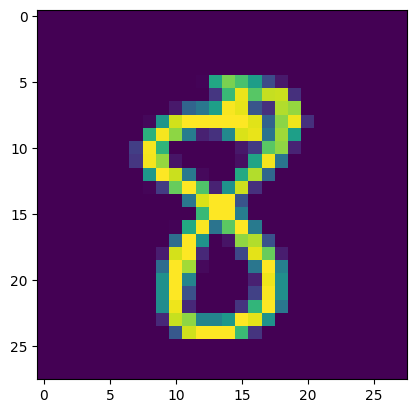

In [249]:
plt.imshow(train[46][0][0].detach().numpy())

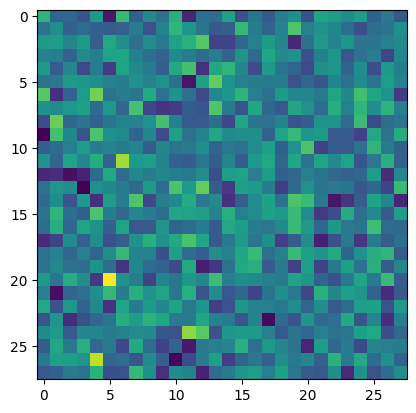

In [250]:
plt.imshow(corrupted_img)

## Prediction with both

In [251]:
corr_tensor = torch.tensor(corrupted_img, dtype=torch.float32)
corr_tensor = corr_tensor.unsqueeze(0).unsqueeze(0)
clean_tensor = torch.tensor(og_img, dtype=torch.float32)
clean_tensor = clean_tensor.unsqueeze(0).unsqueeze(0)


In [256]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    original_output = model(clean_tensor)
    print(model(corr_tensor))

tensor([[ 0.0692,  0.0021,  0.0984,  0.1359,  1.2431,  1.8964, -0.0526,  0.0455,
          0.1542,  0.0865]])


In [257]:
original_output

tensor([[ 0.0087, -0.0270,  0.0520, -0.0033,  0.0033, -0.0095, -0.0054, -0.0199,
          0.8968, -0.0597]])

## Experimenting with weights

In [89]:
linears = mlp.get_linear_layers()
linears

ModuleList(
  (0): BioLinear2D(
    (linear): Linear(in_features=784, out_features=100, bias=True)
  )
  (1): BioLinear2D(
    (linear): Linear(in_features=100, out_features=100, bias=True)
  )
  (2): BioLinear2D(
    (linear): Linear(in_features=100, out_features=10, bias=True)
  )
)

## Activation Patching

In [258]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in model.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

# Get activations for clean and corrupted tensors
model(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()

model(corr_tensor)
corrupted_activations = activations  # Store activations after passing the corrupted tensor


# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []

# Iterate through layers
for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
    num_neurons = clean_act.shape[1]
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in corrupted_activations]
        current_activations[layer_idx] = patched_act

        # print(layer_idx)
        # print(neuron_idx)
        # print(len(current_activations))
        # print(current_activations[1].shape)
        # Forward the patched activations through the subsequent layers
        for subsequent_layer, act in zip(model.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:]):
            # print(subsequent_layer)
            # print(act)
            act = subsequent_layer(act)

        # print(act)
        
        # Compute the improvement using your preferred metric
        improvement = measure_improvement(act, original_output)  # Implement measure_improvement as required
        improvements.append((layer_idx, neuron_idx, improvement))

# Sort neurons by improvement
sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)


In [259]:
improvements

[(0, 0, 6.972023963928223),
 (0, 1, 6.972023963928223),
 (0, 2, 6.972023963928223),
 (0, 3, 6.972023963928223),
 (0, 4, 6.972023963928223),
 (0, 5, 6.972023963928223),
 (0, 6, 6.972023963928223),
 (0, 7, 6.972023963928223),
 (0, 8, 6.972023963928223),
 (0, 9, 6.972023963928223),
 (0, 10, 6.972023963928223),
 (0, 11, 6.972023963928223),
 (0, 12, 6.972023963928223),
 (0, 13, 6.972023963928223),
 (0, 14, 6.972023963928223),
 (0, 15, 6.972023963928223),
 (0, 16, 6.972023963928223),
 (0, 17, 6.972023963928223),
 (0, 18, 6.972023963928223),
 (0, 19, 6.972023963928223),
 (0, 20, 6.972023963928223),
 (0, 21, 6.972023963928223),
 (0, 22, 6.972023963928223),
 (0, 23, 6.972023963928223),
 (0, 24, 6.972023963928223),
 (0, 25, 6.972023963928223),
 (0, 26, 6.972023963928223),
 (0, 27, 6.972023963928223),
 (0, 28, 6.972023963928223),
 (0, 29, 6.972023963928223),
 (0, 30, 6.972023963928223),
 (0, 31, 6.972023963928223),
 (0, 32, 6.972023963928223),
 (0, 33, 6.972023963928223),
 (0, 34, 6.9720239639282

In [74]:
for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
    num_neurons = clean_act.shape[1]
    for neuron_idx in range(num_neurons):
        print(clean_act[0, neuron_idx])

tensor(0.0011, grad_fn=<SelectBackward0>)
tensor(-0.0008, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SelectBackward0>)
tensor(0.0001, grad_fn=<SelectBackward0>)
tensor(0.0004, grad_fn=<SelectBackward0>)
tensor(-0.0025, grad_fn=<SelectBackward0>)
tensor(-0.0002, grad_fn=<SelectBackward0>)
tensor(-0.0012, grad_fn=<SelectBackward0>)
tensor(-0.0004, grad_fn=<SelectBackward0>)
tensor(-0.0016, grad_fn=<SelectBackward0>)
tensor(9.5672e-05, grad_fn=<SelectBackward0>)
tensor(-0.0003, grad_fn=<SelectBackward0>)
tensor(-0.0015, grad_fn=<SelectBackward0>)
tensor(-0.0004, grad_fn=<SelectBackward0>)
tensor(-0.0007, grad_fn=<SelectBackward0>)
tensor(-0.0029, grad_fn=<SelectBackward0>)
tensor(-0.0009, grad_fn=<SelectBackward0>)
tensor(-0.0006, grad_fn=<SelectBackward0>)
tensor(-0.0009, grad_fn=<SelectBackward0>)
tensor(-0.0007, grad_fn=<SelectBackward0>)
tensor(-7.9611e-05, grad_fn=<SelectBackward0>)
tensor(0.0007, grad_fn=<SelectBackward0>)
tensor(-0.0002, grad_fn=<SelectBackward0>)
tensor(-2

In [91]:
sorted_neurons

[(1, 44, 7.059076309204102),
 (1, 75, 10.570867538452148),
 (1, 80, 10.58362102508545),
 (1, 98, 10.828994750976562),
 (1, 31, 10.945387840270996),
 (1, 81, 11.009647369384766),
 (1, 7, 11.021986961364746),
 (1, 9, 11.172467231750488),
 (1, 88, 11.172791481018066),
 (1, 19, 11.186450004577637),
 (1, 26, 11.191346168518066),
 (1, 45, 11.191346168518066),
 (1, 69, 11.191346168518066),
 (1, 71, 11.191346168518066),
 (1, 74, 11.191346168518066),
 (1, 78, 11.191346168518066),
 (1, 86, 11.191346168518066),
 (1, 93, 11.191346168518066),
 (0, 0, 11.191347122192383),
 (0, 1, 11.191347122192383),
 (0, 2, 11.191347122192383),
 (0, 3, 11.191347122192383),
 (0, 4, 11.191347122192383),
 (0, 5, 11.191347122192383),
 (0, 6, 11.191347122192383),
 (0, 7, 11.191347122192383),
 (0, 8, 11.191347122192383),
 (0, 9, 11.191347122192383),
 (0, 10, 11.191347122192383),
 (0, 11, 11.191347122192383),
 (0, 12, 11.191347122192383),
 (0, 13, 11.191347122192383),
 (0, 14, 11.191347122192383),
 (0, 15, 11.191347122192

## Ablation

In [92]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in mlp.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def ablate_zero_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

# Get activations for clean and corrupted tensors
mlp(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()

# mlp(corr_tensor)
# corrupted_activations = activations  # Store activations after passing the corrupted tensor


# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []

# Iterate through layers
for layer_idx, clean_act in enumerate(clean_activations):
    num_neurons = clean_act.shape[1]
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = patch_neuron(clean_act, neuron_idx, 0)

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in clean_activations]
        current_activations[layer_idx] = patched_act

        # Forward the patched activations through the subsequent layers
        for subsequent_layer, act in zip(mlp.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:]):
            # print(subsequent_layer)
            # print(act)
            act = subsequent_layer(act)

        # print(act)
        
        # Compute the improvement using your preferred metric

        improvement = measure_improvement(act, original_output)  # Implement measure_improvement as required
        improvements.append((layer_idx, neuron_idx, improvement, act))

# Sort neurons by improvement
sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=True)

In [93]:
original_output

tensor([[ 0.0243, -0.0156,  0.0868,  0.0288,  0.0126,  0.0554, -0.0147, -0.0078,
          0.9819, -0.0314]])

In [94]:
sorted_neurons[-1]

(1,
 7,
 0.6056037545204163,
 tensor([[-0.0726, -0.1296,  0.0907, -0.0241,  0.1206,  0.0797, -0.4260, -0.2541,
           1.0762, -0.3322]], grad_fn=<AddmmBackward0>))

In [95]:
sorted_neurons

[(1,
  44,
  1.3539360761642456,
  tensor([[-0.0697, -0.1294,  0.0985, -0.0203, -0.8484,  0.0969, -0.4287, -0.2507,
            0.1137, -0.3171]], grad_fn=<AddmmBackward0>)),
 (1,
  28,
  1.2376959323883057,
  tensor([[-0.1756, -0.1798, -0.0158, -0.1170, -0.9423, -0.0050, -0.5079, -0.3462,
            0.9717, -0.4313]], grad_fn=<AddmmBackward0>)),
 (1,
  9,
  1.0473865270614624,
  tensor([[-0.0704, -0.1291,  0.0949,  0.0853, -0.8488,  0.0682, -0.4278, -0.2528,
            1.0767, -0.3316]], grad_fn=<AddmmBackward0>)),
 (1,
  81,
  1.046668529510498,
  tensor([[-0.0701, -0.1292,  0.0953, -0.0261, -0.8478,  0.1048, -0.4259, -0.2527,
            1.0770, -0.3310]], grad_fn=<AddmmBackward0>)),
 (1,
  75,
  1.046316385269165,
  tensor([[-0.0701, -0.1292,  0.1142, -0.0260, -0.8480,  0.0794, -0.4258, -0.2527,
            1.0770, -0.3312]], grad_fn=<AddmmBackward0>)),
 (1,
  98,
  1.0457372665405273,
  tensor([[-0.0699, -0.1293,  0.0949, -0.0257, -0.8725,  0.0795, -0.4262, -0.3127,
            

## Probing

## Correlation maps

# Load the model again

In [260]:
model = BioMLP2D(shp=(784,100,100,10)).to(device)
model.load_state_dict(torch.load('model_state_path.pt'))

<All keys matched successfully>

In [254]:
model2 = BioMLP2D(shp=(784,100,100,10)).to(device)
model2.load_state_dict(torch.load('mnist_no_swap.pt'))

<All keys matched successfully>

In [255]:
model3 = BioMLP2D(shp=(784,100,100,10)).to(device)
model3.load_state_dict(torch.load('mnist_no_nothing.pt'))

<All keys matched successfully>

## Activation Patching

In [261]:
og_img = train[46][0][0].detach().numpy()
gaussian = np.random.normal(0, 10**0.5, (og_img.shape[0],og_img.shape[1])) 
corrupted_img = og_img + gaussian

In [262]:
corr_tensor = torch.tensor(corrupted_img, dtype=torch.float32)
corr_tensor = corr_tensor.unsqueeze(0).unsqueeze(0)
clean_tensor = torch.tensor(og_img, dtype=torch.float32)
clean_tensor = clean_tensor.unsqueeze(0).unsqueeze(0)

In [264]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    original_output = model(clean_tensor)
    print(model(corr_tensor))

tensor([[-0.0048, -0.0119, -0.0602,  0.7304, -0.0018,  0.6978, -0.0864,  0.0025,
         -0.0908,  0.0126]])


In [265]:
original_output

tensor([[ 0.0087, -0.0270,  0.0520, -0.0033,  0.0033, -0.0095, -0.0054, -0.0199,
          0.8968, -0.0597]])

In [274]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in model.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

# Get activations for clean and corrupted tensors
model(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()
# print(clean_activations)
model(corr_tensor)
corrupted_activations = activations  # Store activations after passing the corrupted tensor
# print(corrupted_activations)

# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []

# Iterate through layers
for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
    num_neurons = clean_act.shape[1]
    print(clean_act.shape)
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in corrupted_activations]
        current_activations[layer_idx] = patched_act

        # print(layer_idx)
        # print(neuron_idx)
        # print(len(current_activations))
        # print(current_activations[1].shape)
        # Forward the patched activations through the subsequent layers
        for subsequent_layer, act in zip(model.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:]):
            print(subsequent_layer)
            print(act)
            act = subsequent_layer(act)

        print(act)
        
        # # Compute the improvement using your preferred metric
        # improvement = measure_improvement(act, original_output)  # Implement measure_improvement as required
        # improvements.append((layer_idx, neuron_idx, improvement))
        break
    break
# # Sort neurons by improvement
# sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)


torch.Size([1, 100])
BioLinear2D(
  (linear): Linear(in_features=100, out_features=100, bias=True)
)
tensor([[ 1.0918e-03, -1.6431e-03,  1.1076e-02, -6.1688e-03,  5.2798e-03,
          5.4827e-03, -6.3952e-03, -8.5098e-03, -4.1679e-03,  1.3330e-02,
         -2.5666e-02,  1.3934e-03, -6.2063e-03,  7.2295e-03,  3.1947e-05,
         -3.1157e-02,  2.7036e-03, -1.4455e-02,  1.3209e-02, -7.2201e-04,
          3.2855e-03,  8.0623e-03, -1.2243e-02, -1.2217e+01, -2.4853e+00,
          4.3322e+00, -5.1539e+00, -1.5038e-02,  2.4934e-03, -3.6150e-03,
         -2.7256e-03,  5.0016e-04, -1.6558e+00, -2.1763e+01, -7.2128e+00,
          1.2381e+01, -2.5984e+00, -1.6116e-02, -4.4077e-03, -1.7883e-02,
         -2.8745e-03,  1.7304e+00, -3.6086e+00,  1.8137e+00,  8.3714e+00,
         -2.2803e+00, -9.7082e+00, -5.2182e+00, -6.4782e-03, -1.6010e-03,
         -1.0146e-02,  3.4459e-03, -5.8772e-01,  6.8106e-02,  2.0937e+00,
         -3.3422e+00, -8.0613e+00, -1.7527e+00,  1.1065e-02, -3.1939e-04,
         -5

In [267]:
improvements

[(0, 0, 12.81911563873291),
 (0, 1, 12.81911563873291),
 (0, 2, 12.81911563873291),
 (0, 3, 12.81911563873291),
 (0, 4, 12.81911563873291),
 (0, 5, 12.81911563873291),
 (0, 6, 12.81911563873291),
 (0, 7, 12.81911563873291),
 (0, 8, 12.81911563873291),
 (0, 9, 12.81911563873291),
 (0, 10, 12.81911563873291),
 (0, 11, 12.81911563873291),
 (0, 12, 12.81911563873291),
 (0, 13, 12.81911563873291),
 (0, 14, 12.81911563873291),
 (0, 15, 12.81911563873291),
 (0, 16, 12.81911563873291),
 (0, 17, 12.81911563873291),
 (0, 18, 12.81911563873291),
 (0, 19, 12.81911563873291),
 (0, 20, 12.81911563873291),
 (0, 21, 12.81911563873291),
 (0, 22, 12.81911563873291),
 (0, 23, 12.81911563873291),
 (0, 24, 12.81911563873291),
 (0, 25, 12.81911563873291),
 (0, 26, 12.81911563873291),
 (0, 27, 12.81911563873291),
 (0, 28, 12.81911563873291),
 (0, 29, 12.81911563873291),
 (0, 30, 12.81911563873291),
 (0, 31, 12.81911563873291),
 (0, 32, 12.81911563873291),
 (0, 33, 12.81911563873291),
 (0, 34, 12.819115638732

## ablation

In [277]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in model.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def ablate_zero_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

# Get activations for clean and corrupted tensors
model(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()

# mlp(corr_tensor)
# corrupted_activations = activations  # Store activations after passing the corrupted tensor


# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []

# Iterate through layers
for layer_idx, clean_act in enumerate(clean_activations):
    num_neurons = clean_act.shape[1]
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = ablate_zero_neuron(clean_act, neuron_idx, 0)

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in clean_activations]
        current_activations[layer_idx] = patched_act

        # Forward the patched activations through the subsequent layers
        for subsequent_layer, act in zip(model.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:]):
            # print(subsequent_layer)
            # print(act)
            act = subsequent_layer(act)

        print(act)
        
        # Compute the improvement using your preferred metric

        improvement = measure_improvement(act, original_output)  # Implement measure_improvement as required
        improvements.append((layer_idx, neuron_idx, improvement, act))

# Sort neurons by improvement
sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=True)

tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.0014, -0.1476, -0.0050, -0.2504,
         -0.5765,  0.0118]], grad_fn=<AddmmBackward0>)
tensor([[-0.1255,  1.0030,  0.1134,  0.0095,  0.

In [276]:
sorted_neurons

[(1,
  43,
  1.9755321741104126,
  tensor([[-1.2491e-01,  1.0007e+00,  1.0045e-01,  9.0049e-03,  2.9733e-04,
            5.6235e-01, -4.2042e-02, -5.9931e-01, -5.7183e-01,  1.0968e-02]],
         grad_fn=<AddmmBackward0>)),
 (1,
  24,
  1.8654420375823975,
  tensor([[-0.1262,  1.0053,  0.1095,  0.0143, -0.0056, -0.1482, -0.0025,  0.4373,
           -0.5729,  0.0014]], grad_fn=<AddmmBackward0>)),
 (1,
  52,
  1.8502572774887085,
  tensor([[-0.1284,  0.9955,  0.1085,  0.0046, -0.1232, -0.1477, -0.0058, -0.2518,
           -0.6072,  0.0108]], grad_fn=<AddmmBackward0>)),
 (1,
  53,
  1.8327741622924805,
  tensor([[-0.1255,  1.0023,  0.1143, -0.0431,  0.1691, -0.1475, -0.0047, -0.2510,
           -0.5766,  0.0121]], grad_fn=<AddmmBackward0>)),
 (1,
  63,
  1.8260602951049805,
  tensor([[-0.1255,  1.0032,  0.1135,  0.0461,  0.0013, -0.1477, -0.0058, -0.2504,
           -0.5768,  0.0118]], grad_fn=<AddmmBackward0>)),
 (1,
  33,
  1.825819730758667,
  tensor([[-1.2558e-01,  1.0022e+00,  1.0866

## Superposition please please please

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [107]:
# [784,100,100,10]
for p in model2.parameters():
    print(p.shape)
    # if p.shape==torch.Size([10, 100]):
    #     W = p.T

# W.shape

torch.Size([784])
torch.Size([10])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


torch.Size([100, 10])

In [106]:
W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, W)
interference[torch.arange(20), torch.arange(20)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(W, 2, dim=-1).cpu()

WtW = torch.einsum('ih,oh->io', W, W).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(20)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

torch.Size([100])
tensor([3.4450e-04, 4.2833e-04, 2.4820e-04, 2.0166e-04, 3.6509e-04, 5.4661e-04,
        3.8858e-04, 3.9765e-01, 3.9107e-04, 3.3300e-01, 3.1780e-04, 4.7229e-04,
        3.4572e-04, 4.3911e-04, 4.8730e-04, 4.1449e-04, 2.7890e-04, 4.8035e-04,
        3.2926e-04, 2.6069e-01, 3.3888e-04, 3.9645e-04, 4.2838e-04, 5.0594e-04,
        6.6091e-04, 4.1578e-04, 3.2935e-04, 3.0289e-04, 1.4818e-01, 3.4752e-04,
        3.7549e-04, 3.3568e-01, 2.7815e-04, 3.0359e-04, 2.8460e-04, 3.4971e-04,
        3.1442e-04, 4.8190e-04, 4.3297e-04, 2.4874e-04, 4.2783e-04, 4.3999e-04,
        2.7613e-04, 4.7275e-04, 3.9314e-01, 3.7011e-04, 3.6863e-04, 2.5346e-04,
        2.5609e-04, 2.3376e-04, 4.0394e-04, 3.0172e-04, 4.1130e-04, 4.0036e-04,
        3.4822e-04, 3.7346e-04, 4.0838e-04, 2.7149e-04, 4.5876e-04, 3.8837e-04,
        4.4444e-04, 3.1449e-04, 3.3320e-04, 4.7815e-04, 3.4099e-04, 4.4504e-04,
        3.9217e-04, 3.4813e-04, 4.2905e-04, 4.9568e-04, 3.5270e-04, 3.7284e-04,
        5.0209e-04, 4.

## Superposition v2

### BIMT

In [112]:
i = 1
top_k = 784
linears = model.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
#print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]

In [122]:
features = model.linears[0].linear.weight[top_index].T
features.shape

torch.Size([784, 100])

In [126]:
torch.linalg.norm(features, 2, dim=-1).cpu()

tensor([9.5724e-04, 1.0007e-03, 8.1676e-04, 1.0136e-03, 9.4767e-04, 9.9207e-04,
        1.0573e-03, 8.5591e-04, 1.0208e-03, 1.0465e-03, 8.5214e-04, 8.5309e-04,
        1.1414e-03, 1.2880e-03, 1.1401e-03, 1.0166e-03, 1.1412e-03, 8.6556e-04,
        9.8850e-04, 1.0352e-03, 9.0119e-04, 9.3524e-04, 7.1834e-04, 1.0085e-03,
        9.3397e-04, 9.7182e-04, 9.9908e-04, 9.6807e-04, 8.8348e-04, 9.2457e-04,
        8.8780e-04, 9.0507e-04, 1.1136e-03, 9.9334e-04, 1.0700e-03, 1.0870e-03,
        1.1409e-03, 1.5299e-03, 1.3367e-03, 1.5247e-03, 1.4200e-03, 1.4017e-03,
        1.5132e-03, 1.7160e-03, 1.6030e-03, 1.2648e-03, 1.3141e-03, 1.1629e-03,
        1.1545e-03, 1.4240e-03, 1.1049e-03, 1.1105e-03, 8.8036e-04, 8.9850e-04,
        9.4247e-04, 7.1930e-04, 9.0039e-04, 9.7137e-04, 1.0703e-03, 1.0866e-03,
        1.2891e-03, 1.1301e-03, 1.2623e-03, 1.4729e-03, 2.0230e-03, 1.6269e-03,
        1.5578e-02, 2.9870e-03, 3.0324e-03, 2.6741e-03, 1.7793e-03, 8.3683e-03,
        3.0981e-03, 3.8717e-03, 1.2303e-

In [127]:
W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, features)
interference[torch.arange(784), torch.arange(784)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()

WtW = torch.einsum('ih,oh->io', features, features).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(784)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

torch.Size([784])
tensor([9.5724e-04, 1.0007e-03, 8.1676e-04, 1.0136e-03, 9.4767e-04, 9.9207e-04,
        1.0573e-03, 8.5591e-04, 1.0208e-03, 1.0465e-03, 8.5214e-04, 8.5309e-04,
        1.1414e-03, 1.2880e-03, 1.1401e-03, 1.0166e-03, 1.1412e-03, 8.6556e-04,
        9.8850e-04, 1.0352e-03, 9.0119e-04, 9.3524e-04, 7.1834e-04, 1.0085e-03,
        9.3397e-04, 9.7182e-04, 9.9908e-04, 9.6807e-04, 8.8348e-04, 9.2457e-04,
        8.8780e-04, 9.0507e-04, 1.1136e-03, 9.9334e-04, 1.0700e-03, 1.0870e-03,
        1.1409e-03, 1.5299e-03, 1.3367e-03, 1.5247e-03, 1.4200e-03, 1.4017e-03,
        1.5132e-03, 1.7160e-03, 1.6030e-03, 1.2648e-03, 1.3141e-03, 1.1629e-03,
        1.1545e-03, 1.4240e-03, 1.1049e-03, 1.1105e-03, 8.8036e-04, 8.9850e-04,
        9.4247e-04, 7.1930e-04, 9.0039e-04, 9.7137e-04, 1.0703e-03, 1.0866e-03,
        1.2891e-03, 1.1301e-03, 1.2623e-03, 1.4729e-03, 2.0230e-03, 1.6269e-03,
        1.5578e-02, 2.9870e-03, 3.0324e-03, 2.6741e-03, 1.7793e-03, 8.3683e-03,
        3.0981e-03, 3.

### L1 

In [134]:
i = 2
top_k = 100
linears = model2.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    print("here haha")
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]

features = model2.linears[1].linear.weight[top_index].T
features.shape

here haha
torch.Size([100])


In [136]:
features = model2.linears[1].linear.weight[top_index].T
features.shape

torch.Size([100, 100])

In [140]:
W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, features)
print(interference)
interference[torch.arange(100), torch.arange(100)] = 0
print(interference)

tensor([[ 6.0702e-01, -2.8275e-01,  1.8475e-01,  ..., -3.4057e-05,
         -2.9689e-02,  1.7929e-02],
        [-4.1276e-01,  4.1582e-01, -5.5665e-03,  ...,  7.4687e-06,
          3.0792e-01, -4.3354e-03],
        [ 1.5915e-01, -3.2847e-03,  7.0469e-01,  ...,  6.8797e-05,
          1.8631e-01, -4.6254e-02],
        ...,
        [-1.6654e-02,  2.5019e-03,  3.9055e-02,  ...,  1.2214e-03,
         -5.4346e-02, -6.1854e-02],
        [-2.4481e-02,  1.7394e-01,  1.7834e-01,  ..., -9.1641e-05,
          7.3615e-01,  1.7346e-01],
        [ 1.3548e-02, -2.2443e-03, -4.0577e-02,  ..., -9.5583e-05,
          1.5896e-01,  8.0329e-01]], grad_fn=<ViewBackward0>)
tensor([[ 0.0000e+00, -2.8275e-01,  1.8475e-01,  ..., -3.4057e-05,
         -2.9689e-02,  1.7929e-02],
        [-4.1276e-01,  0.0000e+00, -5.5665e-03,  ...,  7.4687e-06,
          3.0792e-01, -4.3354e-03],
        [ 1.5915e-01, -3.2847e-03,  0.0000e+00,  ...,  6.8797e-05,
          1.8631e-01, -4.6254e-02],
        ...,
        [-1.6654e-02,

In [138]:
W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, features)
interference[torch.arange(100), torch.arange(100)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()

WtW = torch.einsum('ih,oh->io', features, features).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(100)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

torch.Size([100])
tensor([6.0703e-01, 4.1583e-01, 7.0470e-01, 1.3392e-03, 1.0732e+00, 5.1398e-01,
        3.4828e-01, 8.9206e-01, 1.1482e-03, 7.7285e-01, 5.2630e-01, 7.5633e-01,
        1.3353e-03, 3.5966e-01, 5.7192e-01, 7.7786e-01, 6.9474e-01, 1.0350e+00,
        8.2626e-01, 1.1593e-03, 4.8703e-01, 1.2836e-03, 9.7178e-01, 6.4955e-01,
        1.1660e-03, 1.3135e-03, 1.3897e-03, 1.2459e-03, 8.1419e-01, 1.5185e-03,
        1.8336e+00, 4.0383e-01, 7.3769e-01, 7.7414e-01, 1.2620e-03, 1.1927e-03,
        5.9302e-01, 1.1994e-03, 1.0270e-03, 7.3111e-01, 1.3124e-03, 1.2186e+00,
        4.9127e-01, 2.8694e-01, 1.2894e-03, 1.3033e-03, 5.2485e-01, 9.2633e-01,
        1.1822e-03, 1.2226e-03, 8.0577e-01, 7.0378e-01, 1.0871e+00, 6.4475e-01,
        9.5949e-01, 4.3701e-01, 7.9797e-01, 1.7870e+00, 3.3873e-01, 9.6299e-01,
        6.8427e-01, 7.1450e-01, 5.3528e-01, 7.1000e-01, 1.2723e-03, 1.2648e-03,
        7.3034e-01, 1.1790e-03, 8.1522e-01, 5.5043e-01, 1.2724e-03, 1.2980e-03,
        7.8066e-01, 7.

### No Reg

In [146]:

i = 2
top_k = 100
linears = model3.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    print("here haha")
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]

features = model3.linears[1].linear.weight[top_index].T
features.shape

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
interference = torch.einsum('fh,gh->fg', W_norm, features)
interference[torch.arange(100), torch.arange(100)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()

WtW = torch.einsum('ih,oh->io', features, features).cpu()
print(polysemanticity.shape)
print(norms)

x = torch.arange(100)
width = 0.9
fig = go.Figure(go.Bar(x=x.detach().numpy(), 
        y=norms.detach().numpy(),
        marker=dict(
            color=polysemanticity.detach().numpy(),
            cmin=0,
            cmax=1
        ),
        width=width,
        ))
fig.show()

here haha
torch.Size([100])
torch.Size([100])
tensor([0.9550, 1.1656, 1.3527, 1.6763, 1.3801, 1.4647, 1.0460, 1.9347, 1.4829,
        1.4431, 2.0092, 1.4392, 1.8169, 2.0363, 1.2939, 1.3738, 2.6363, 1.4400,
        1.5524, 1.1675, 1.9023, 1.1487, 2.0233, 1.3054, 1.4660, 1.3363, 1.2598,
        1.0623, 1.0445, 2.4403, 1.0124, 1.1943, 1.6378, 1.5972, 1.6074, 1.0374,
        1.2721, 1.7470, 2.1325, 1.8645, 1.7815, 1.6246, 1.5043, 1.7923, 1.5875,
        1.3500, 2.2434, 2.2795, 1.8492, 1.8267, 1.6295, 1.2155, 1.0995, 1.2638,
        2.5076, 1.5073, 1.5265, 1.6610, 1.7549, 1.4056, 1.7463, 1.1864, 2.5643,
        1.3995, 1.4409, 1.3310, 1.5712, 1.7010, 1.1773, 1.5799, 1.0702, 2.2995,
        1.7046, 1.2254, 1.4125, 1.5024, 1.3668, 1.8090, 1.8644, 1.8231, 1.7343,
        1.8745, 1.7965, 1.3052, 1.1848, 1.9770, 1.6925, 1.6115, 2.2429, 1.1786,
        1.8545, 1.2853, 1.5750, 1.4571, 1.5071, 1.3769, 1.2857, 1.6283, 1.7293,
        0.9454], grad_fn=<LinalgVectorNormBackward0>)


## Super Position v3

In [3]:
model = BioMLP2D(shp=(784,100,100,10)).to(device)
model.load_state_dict(torch.load('mnist_bimt_v1.pt'))

<All keys matched successfully>

In [14]:
polysemanticity.shape

torch.Size([784])

In [36]:
linears = model.get_linear_layers()
W = linears[0].linear.weight.T
n_features = W.shape[0]
n_hidden = W.shape[1]
print(W.shape)
score = torch.sum(torch.abs(W), dim=1)
print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])
# print(top_index)
features = W[top_index]
print(features.shape)

# print(features.shape)
# print(W)

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
print(W_norm.shape)
# print(W_norm)
interference = torch.einsum('fh,gh->fg', W_norm, features)
print(interference.shape)
interference[torch.arange(n_features), torch.arange(n_features)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
print(polysemanticity.shape)
norms = torch.linalg.norm(features, 2, dim=-1).cpu()
norms_bimt = norms
x = torch.arange(n_features)
width = 0.9
fig = px.bar(x=x.detach().numpy(), y=norms.detach().numpy(), width=1000)
fig.update_traces(marker_color='black')
fig.update_xaxes(title_text='Input Feature')
fig.update_yaxes(title_text='||W||')
fig.update_layout(width=1000, height=500)
fig.show()
# width = 0.9
# fig = go.Figure(go.Bar(x=x.detach().numpy(), 
#         y=norms.detach().numpy(),
#         marker=dict(
#             color=[255]*784,
#         ),
#         width=width,
#         ))
# fig.show()

torch.Size([784, 100])
torch.Size([784])
torch.Size([784, 100])
torch.Size([784, 100])
torch.Size([784, 784])
torch.Size([784])


In [168]:
print(polysemanticity)

tensor([2.5536, 3.2764, 3.4936, 2.6940, 3.5153, 2.4619, 2.5210, 2.5892, 2.7078,
        2.4539, 2.6256, 2.5456, 3.0233, 3.5052, 2.5871, 2.6772, 2.7758, 3.5325,
        2.4876, 2.9317, 2.9830, 2.4970, 2.5825, 3.6494, 2.2030, 2.8847, 2.5679,
        2.7938, 2.4193, 2.9314, 3.1149, 2.7126, 3.0962, 2.3297, 2.5665, 3.1938,
        2.7238, 2.3828, 2.5344, 2.7176, 2.6002, 2.9457, 2.3622, 2.2944, 2.9320,
        2.5851, 2.5349, 2.3340, 2.4488, 2.3216, 2.3904, 2.8144, 3.4080, 3.5903,
        2.7608, 2.0759, 2.6668, 2.1998, 2.1304, 2.2886, 2.4574, 3.0547, 2.3226,
        2.2769, 2.4355, 2.2179, 2.6584, 2.6329, 3.2838, 3.0532, 2.2732, 2.5254,
        2.9319, 2.4228, 2.7387, 2.4473, 2.2151, 2.9013, 2.2934, 3.1870, 2.1200,
        3.5391, 2.3778, 2.6952, 2.7130, 2.9063, 2.3828, 2.4457, 2.6386, 2.2410,
        2.8042, 3.2697, 2.5561, 2.2137, 2.3398, 3.3279, 3.2073, 2.2067, 2.7597,
        2.2364, 2.5145, 2.1544, 2.3406, 3.1710, 2.9609, 1.8180, 3.1397, 2.6106,
        2.3807, 2.0785, 2.9285, 2.3544, 

In [37]:

model2 = BioMLP2D(shp=(784,100,100,10)).to(device)
model2.load_state_dict(torch.load('mnist_no_swap.pt'))

linears = model2.get_linear_layers()
W = linears[0].linear.weight.T
n_features = W.shape[0]
n_hidden = W.shape[1]
print(W.shape)
score = torch.sum(torch.abs(W), dim=1)
print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])
# print(top_index)
features = model2.linears[0].linear.weight.T[top_index]
print(features.shape)

# print(features.shape)
# print(W)

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
print(W_norm.shape)
# print(W_norm)
interference = torch.einsum('fh,gh->fg', W_norm, features)
print(interference.shape)
interference[torch.arange(n_features), torch.arange(n_features)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()
norms_l1 = norms
x = torch.arange(n_features)
width = 0.9
fig = px.bar(x=x.detach().numpy(), y=norms.detach().numpy(), width=1000)
fig.update_traces(marker_color='black')
fig.update_xaxes(title_text='Input Feature')
fig.update_yaxes(title_text='||W||')
fig.update_layout(width=1000, height=500)
fig.show()
# x = torch.arange(n_features)
# width = 0.9
# fig = go.Figure(go.Bar(x=x.detach().numpy(), 
#         y=norms.detach().numpy(),
#         marker=dict(
#             color=polysemanticity.detach().numpy(),
#             cmin=0,
#             cmax=1
#         ),
#         width=width,
#         ))
# fig.show()

torch.Size([784, 100])
torch.Size([784])
torch.Size([784, 100])
torch.Size([784, 100])
torch.Size([784, 784])


In [38]:

model3 = BioMLP2D(shp=(784,100,100,10)).to(device)
model3.load_state_dict(torch.load('mnist_no_nothing.pt'))

linears = model3.get_linear_layers()
W = linears[0].linear.weight.T
n_features = W.shape[0]
n_hidden = W.shape[1]
print(W.shape)
score = torch.sum(torch.abs(W), dim=1)
print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])
# print(top_index)
features = model3.linears[0].linear.weight.T[top_index]
print(features.shape)

# print(features.shape)
# print(W)

W_norm = features / (1e-5 + torch.linalg.norm(features, 2, dim=-1, keepdim=True))
print(W_norm.shape)
# print(W_norm)
interference = torch.einsum('fh,gh->fg', W_norm, features)
print(interference.shape)
interference[torch.arange(n_features), torch.arange(n_features)] = 0
polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

norms = torch.linalg.norm(features, 2, dim=-1).cpu()
norms_noreg = norms
x = torch.arange(n_features)
width = 0.9
fig = px.bar(x=x.detach().numpy(), y=norms.detach().numpy(), width=1000)
fig.update_traces(marker_color='black')
fig.update_xaxes(title_text='Input Feature')
fig.update_yaxes(title_text='||W||')
fig.update_layout(width=1000, height=500)
fig.show()

torch.Size([784, 100])
torch.Size([784])
torch.Size([784, 100])
torch.Size([784, 100])
torch.Size([784, 784])


In [39]:
# norm_diff = norms_l1 - norms_bimt
# x = torch.arange(n_features)
# width = 0.9
# fig = px.bar(x=x.detach().numpy(), y=norm_diff.detach().numpy(), width=1000)
# fig.update_traces(marker_color='black')
# fig.update_xaxes(title_text='Input Feature')
# fig.update_yaxes(title_text='||W||')
# fig.update_layout(width=1000, height=500)
# fig.show()

In [40]:
norm_diff = norms_noreg - norms_bimt
x = torch.arange(n_features)
width = 0.9
fig = px.bar(x=x.detach().numpy(), y=norm_diff.detach().numpy(), width=1000)
fig.update_traces(marker_color='black')
fig.update_xaxes(title_text='Input Feature')
fig.update_yaxes(title_text='||W||')
fig.update_layout(width=1000, height=500)
fig.show()

In [47]:
fig = go.Figure()
x = torch.arange(n_features)
# Plot the first bar plot
# Plot the second bar plot

# Plot the second bar plot
fig.add_trace(go.Bar(
    x=x.detach().numpy(), 
    y=norms_noreg.detach().numpy(),
    name='No Regularization',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=x.detach().numpy(), 
    y=norms_l1.detach().numpy(),
    name='L1 Only',
    marker_color='red'
))

fig.add_trace(go.Bar(
    x=x.detach().numpy(), 
    y=norms_bimt.detach().numpy(),
    name='BIMT',
    marker_color='blue'
))

fig.update_xaxes(title_text='Input Feature')
fig.update_yaxes(title_text='||W||')
fig.update_layout(width=1500, height=800)

# Overlaying the plots on the same axes
fig.update_layout(barmode='overlay')

# Show the plot
fig.show()

# Percent Sparsity 

### BIMT

0
20
40
60
80
0
20
40
60
80
0


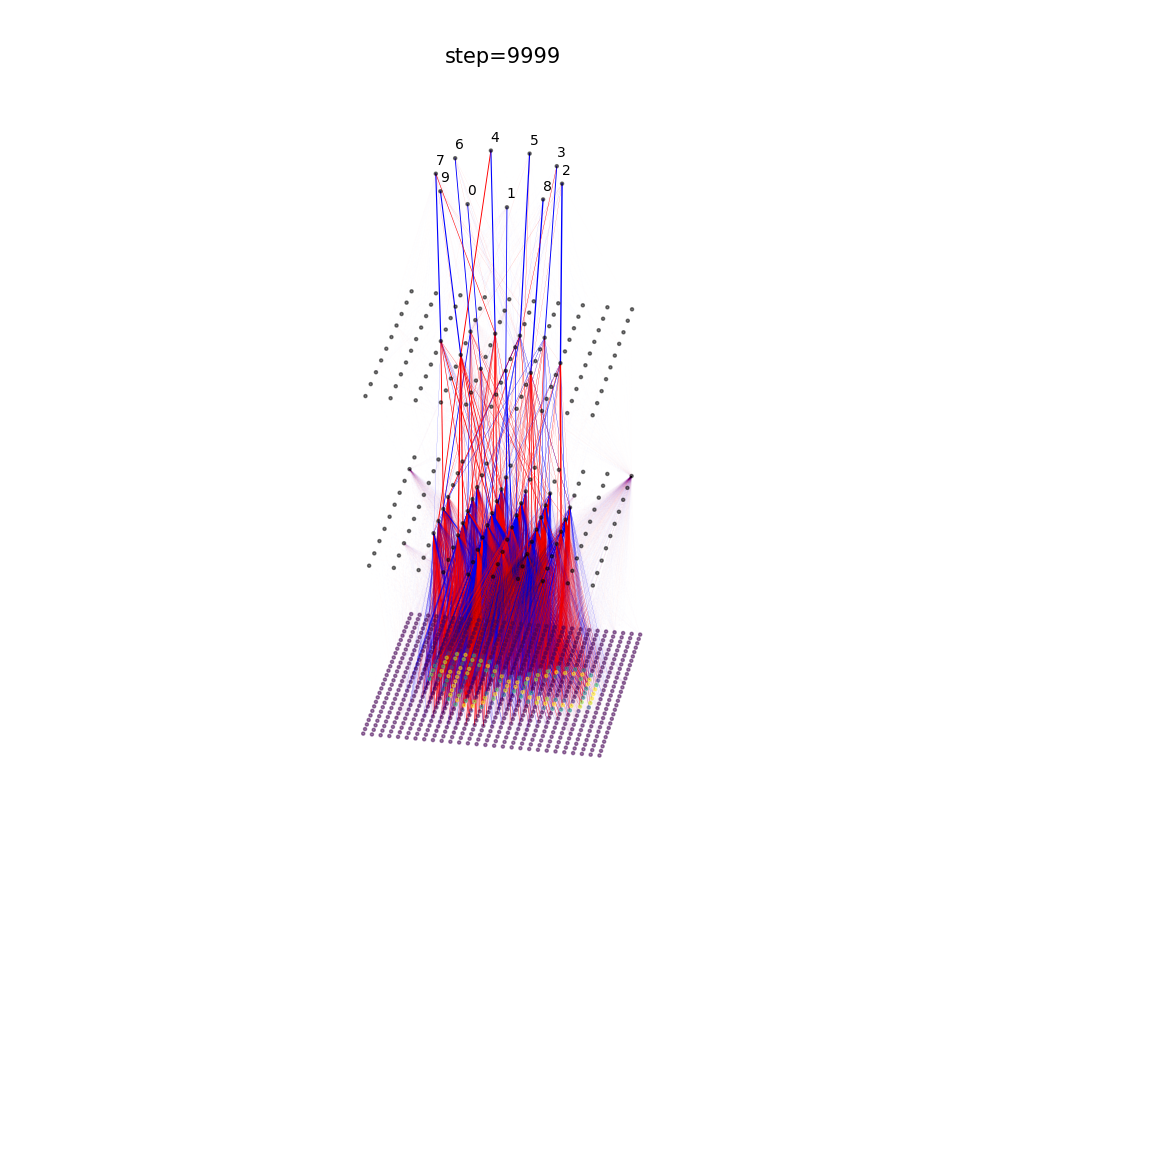

In [173]:
model

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(model.linears[0].in_coordinates[:,0].detach().numpy(), model.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(model.linears[1].in_coordinates[:,0].detach().numpy(), model.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(model.linears[2].in_coordinates[:,0].detach().numpy(), model.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(model.linears[2].out_coordinates[:,0].detach().numpy(), model.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = model.linears[ii]
    p = biolinear.linear.weight.clone()
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = model.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(model.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [51]:
linears = model.get_linear_layers()
W = linears[0].linear.weight.T.detach().numpy()
n_sparsity = (np.abs(W)<0.0009).sum()
print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

Percentage Sparsity: 0.8580994897959183


In [239]:
np.max(np.abs(W))

1.5210574

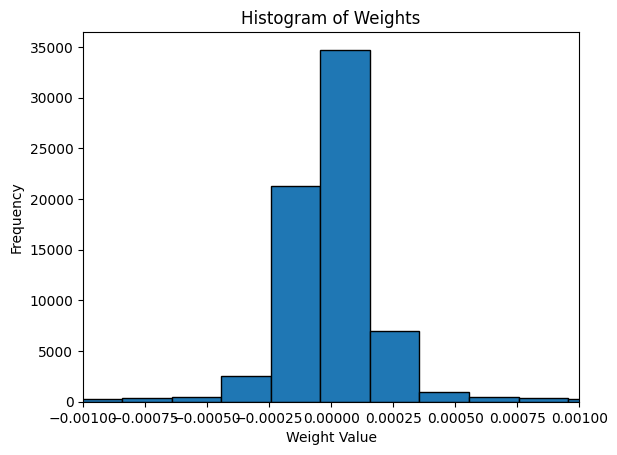

In [245]:
W_flat = W.flatten()
plt.hist(W_flat, bins=10000, edgecolor='black')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')
plt.xlim(-0.001, 0.001)
plt.show()

In [219]:
n_sparsity = (np.abs(W)<0.0009).sum()
print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

Percentage Sparsity: 0.8677933673469388


In [192]:
# no_sparsed = np.sum(np.where(np.abs(W)<0.0009, 0, 1))

10365

In [191]:
# W.shape

(784, 100)

## L1 

0
20
40
60
80
0
20
40
60
80
0


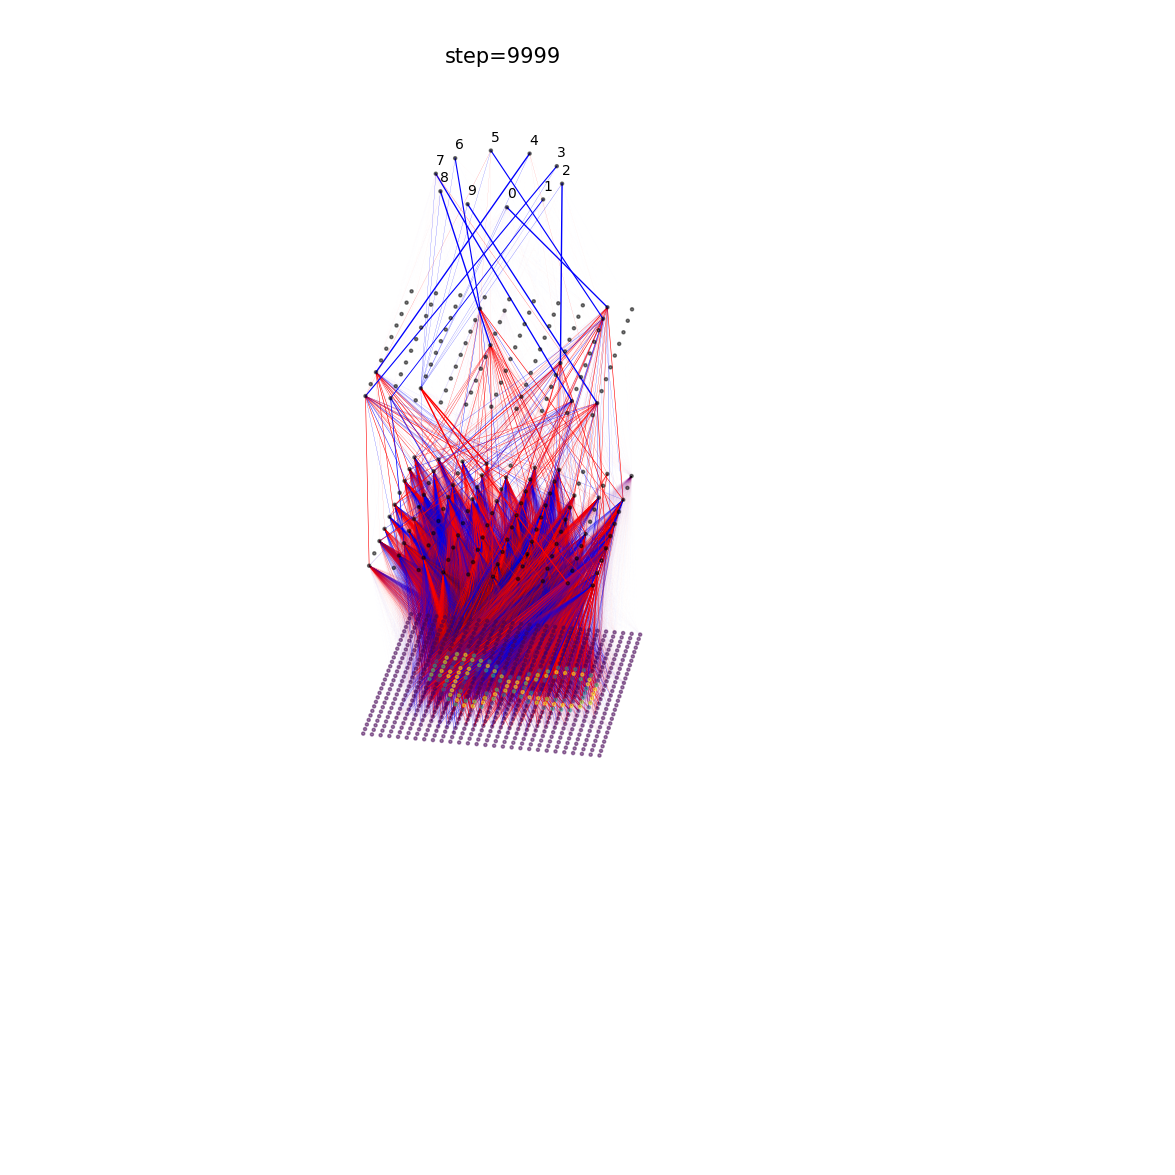

In [174]:
model2

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(model2.linears[0].in_coordinates[:,0].detach().numpy(), model2.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(model2.linears[1].in_coordinates[:,0].detach().numpy(), model2.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(model2.linears[2].in_coordinates[:,0].detach().numpy(), model2.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(model2.linears[2].out_coordinates[:,0].detach().numpy(), model2.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = model2.linears[ii]
    p = biolinear.linear.weight.clone()
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = model2.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(model2.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [246]:
linears = model2.get_linear_layers()
W = linears[0].linear.weight.T.detach().numpy()
# np.median(np.abs(W))
n_sparsity = (np.abs(W)<0.0009).sum()
print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

Percentage Sparsity: 0.6966071428571429


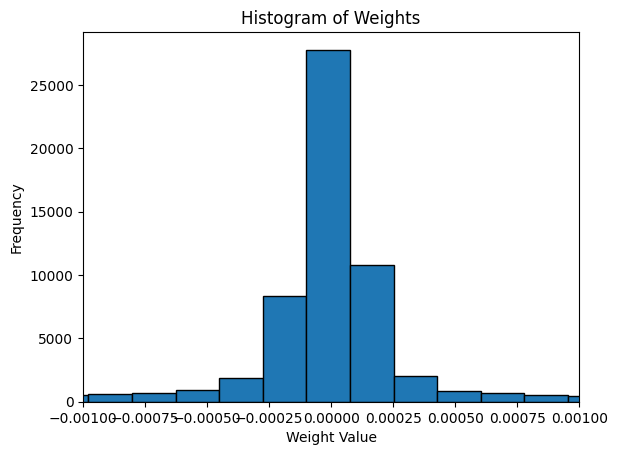

In [247]:
W_flat = W.flatten()
plt.hist(W_flat, bins=10000, edgecolor='black')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')
plt.xlim(-0.001, 0.001)
plt.show()

## No Reg

0
20
40
60
80
0
20
40
60
80
0


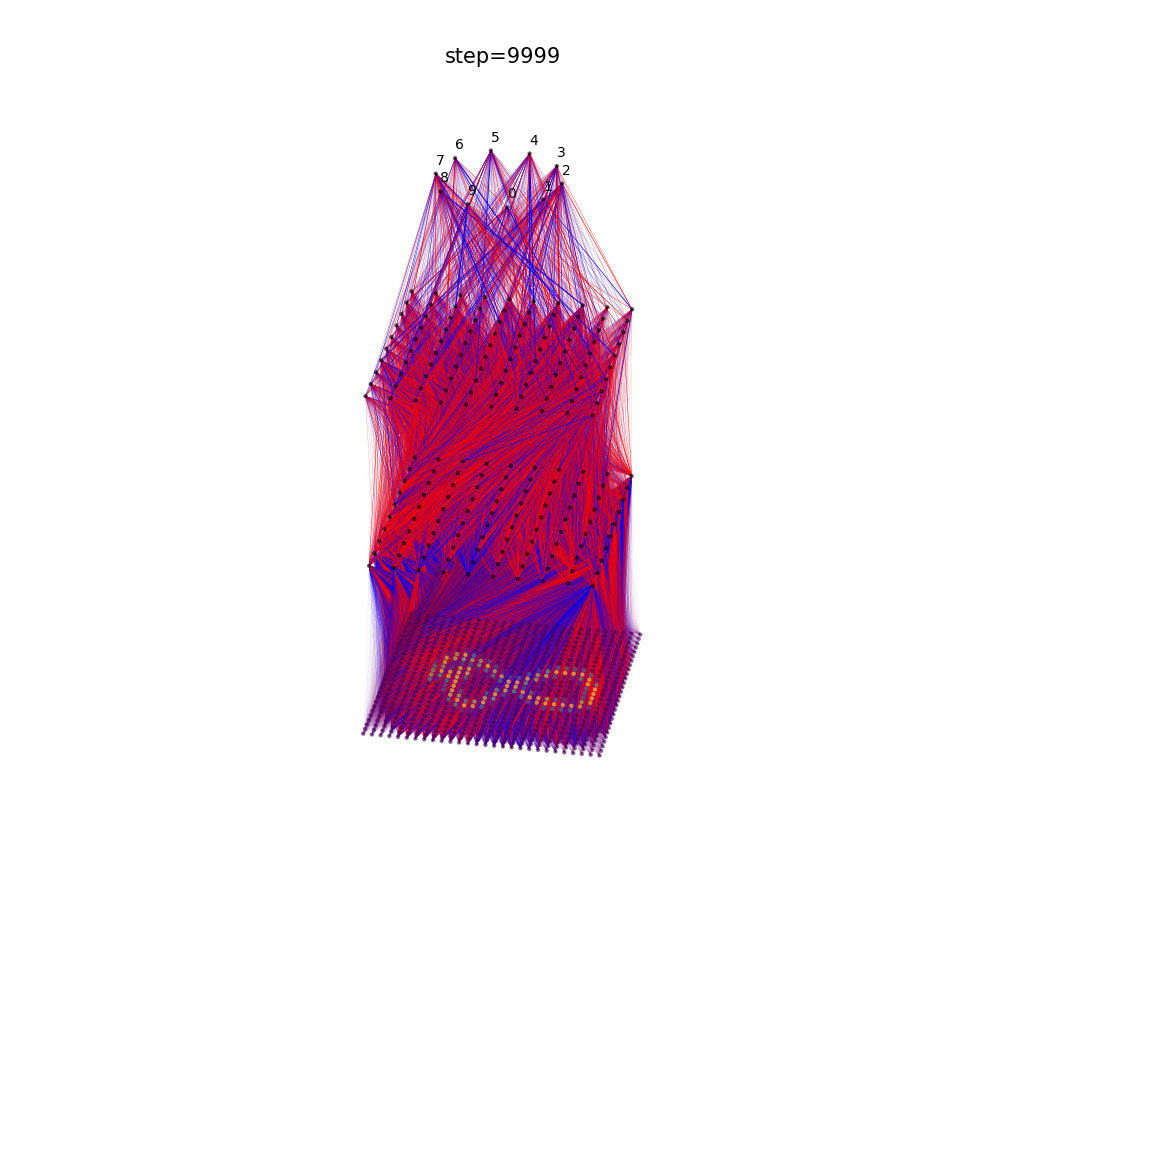

In [175]:
model3

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(model3.linears[0].in_coordinates[:,0].detach().numpy(), model3.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(model3.linears[1].in_coordinates[:,0].detach().numpy(), model3.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(model3.linears[2].in_coordinates[:,0].detach().numpy(), model3.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(model3.linears[2].out_coordinates[:,0].detach().numpy(), model3.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = model3.linears[ii]
    p = biolinear.linear.weight.clone()
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = model3.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(model3.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [227]:
linears = model3.get_linear_layers()
W = linears[0].linear.weight.T.detach().numpy()
# np.median(np.abs(W))
n_sparsity = (np.abs(W)<0.0009).sum()
print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

Percentage Sparsity: 0.007372448979591837


# Plot other things

In [ ]:
class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



Text(0, 0.5, 'Score')

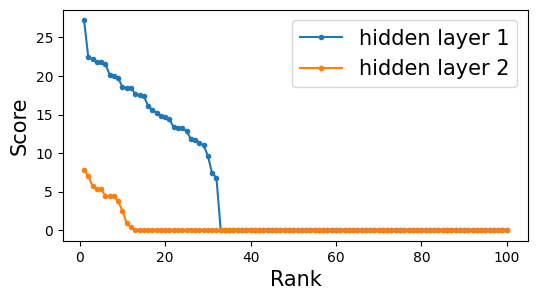

In [10]:
plt.figure(figsize=(6,3))

for i in range(1,3):
    top_k = 784
    linears = mlp.get_linear_layers()
    num_linear = len(linears)
    if i == 0:
        # input layer
        weights = linears[i].linear.weight
        score = torch.sum(torch.abs(weights), dim=0)
        in_fold = linears[0].in_fold
        #print(score.shape)
        score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
    elif i == num_linear:
        # output layer
        weights = linears[i-1].linear.weight
        score = torch.sum(torch.abs(weights), dim=1)
    else:
        weights_in = linears[i-1].linear.weight
        weights_out = linears[i].linear.weight
        score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
    #print(score.shape)
    top_index = torch.flip(torch.argsort(score),[0])[:top_k]
    score = score[top_index]

    num = score.shape[0]

    plt.plot(np.arange(num)+1, score.detach().numpy(), marker="o", markersize=3)

#plt.xscale('log')

plt.legend(["hidden layer 1", "hidden layer 2"], fontsize=15)
plt.xlabel("Rank", fontsize=15)
plt.ylabel("Score", fontsize=15)

In [108]:
i = 1
top_k = 784
linears = mlp.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
#print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]

In [109]:
features = mlp.linears[0].linear.weight[top_index].reshape(100,28,28).detach().numpy()

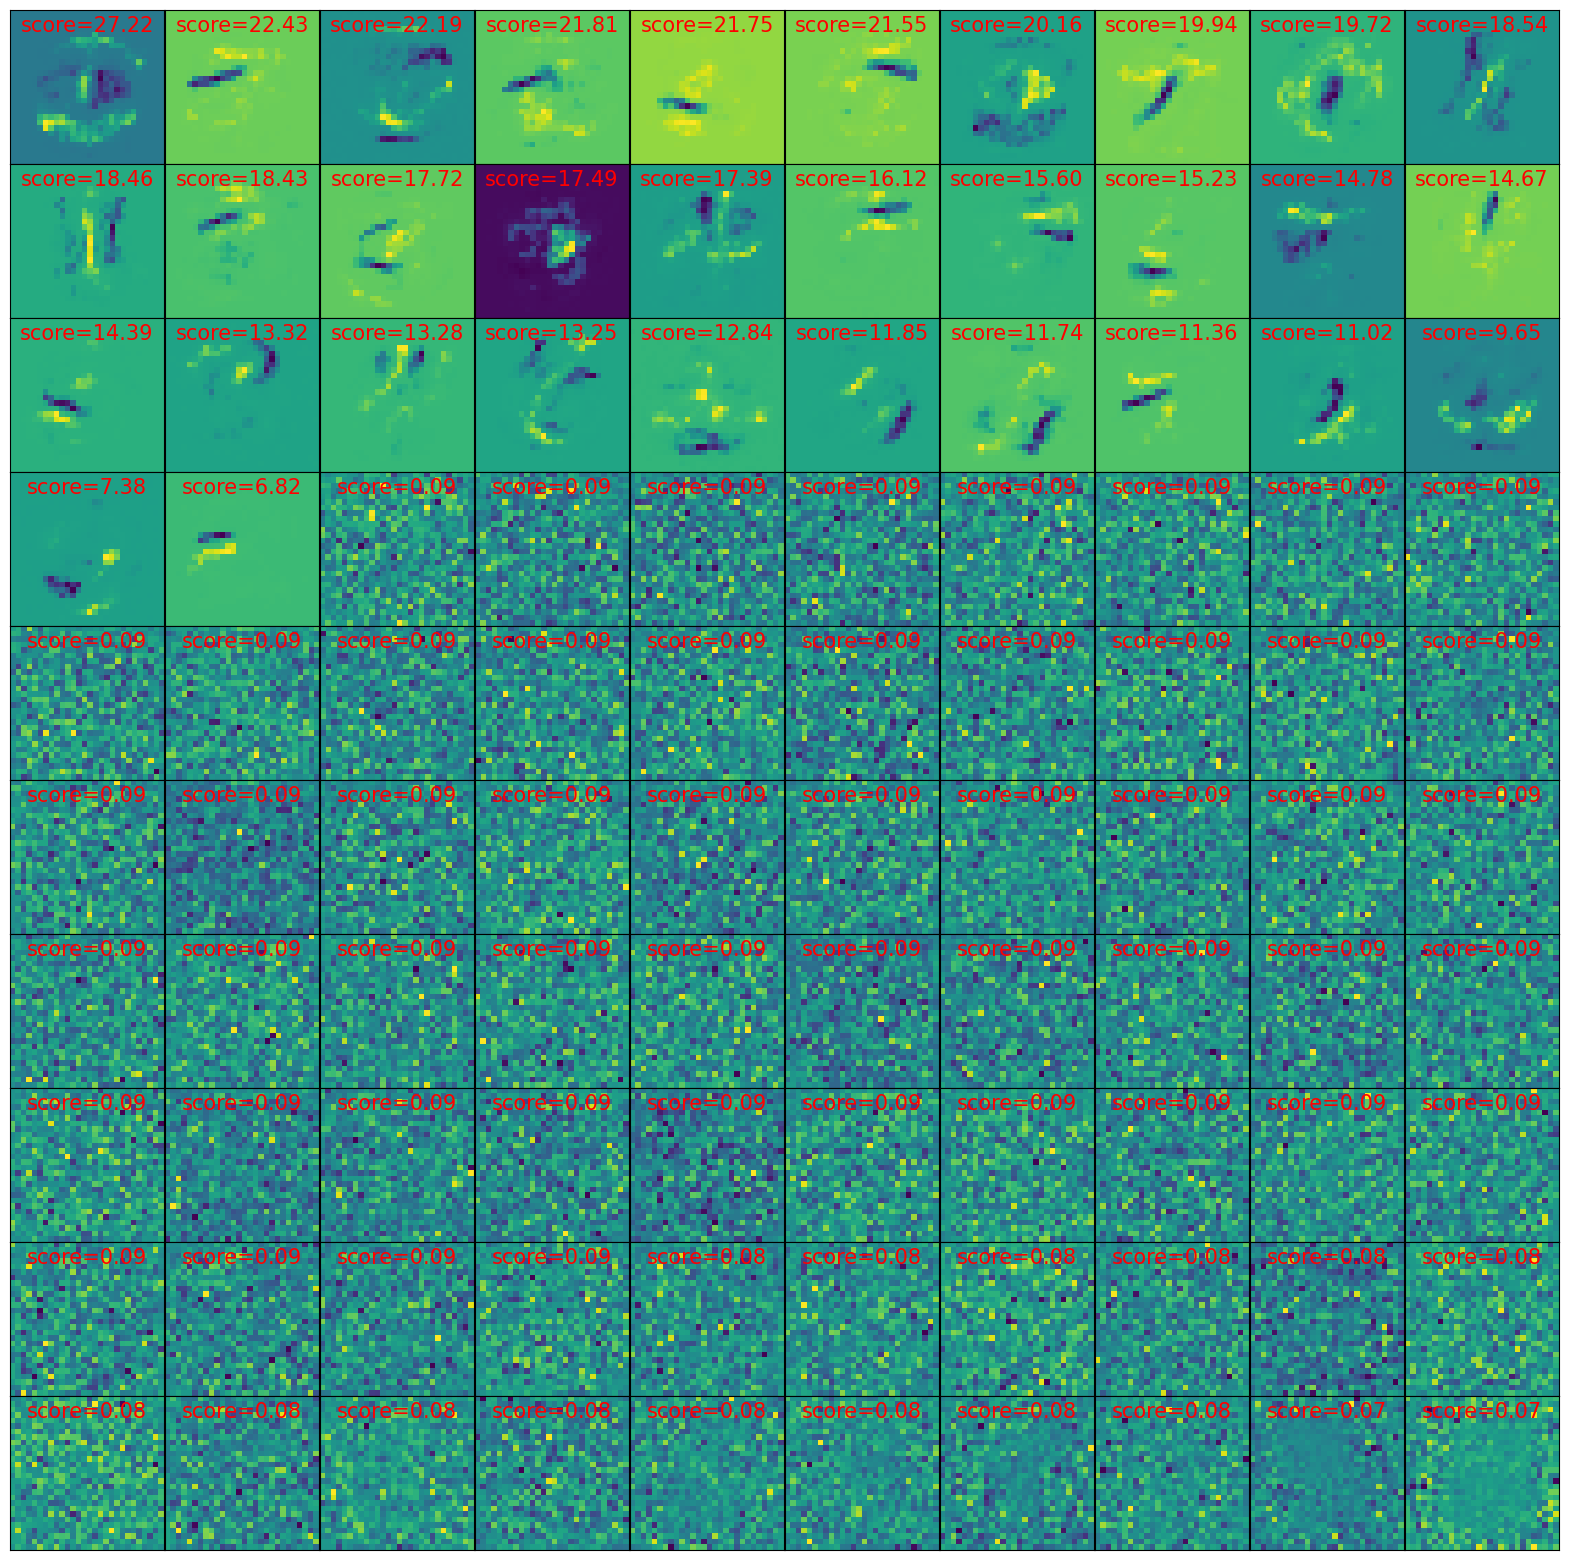

In [13]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("score=%.2f"%(score[i]), color="red", fontsize=15,y=0.8)


plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("./fig/mnist_features.pdf", bbox_inches="tight")

In [14]:
im_f2 = torch.argsort(mlp.linears[2].linear.weight[4])[-1]
im_f1 = torch.argsort(mlp.linears[1].linear.weight[im_f2,:])
features = mlp.linears[0].linear.weight[im_f1].reshape(100,28,28).detach().numpy()

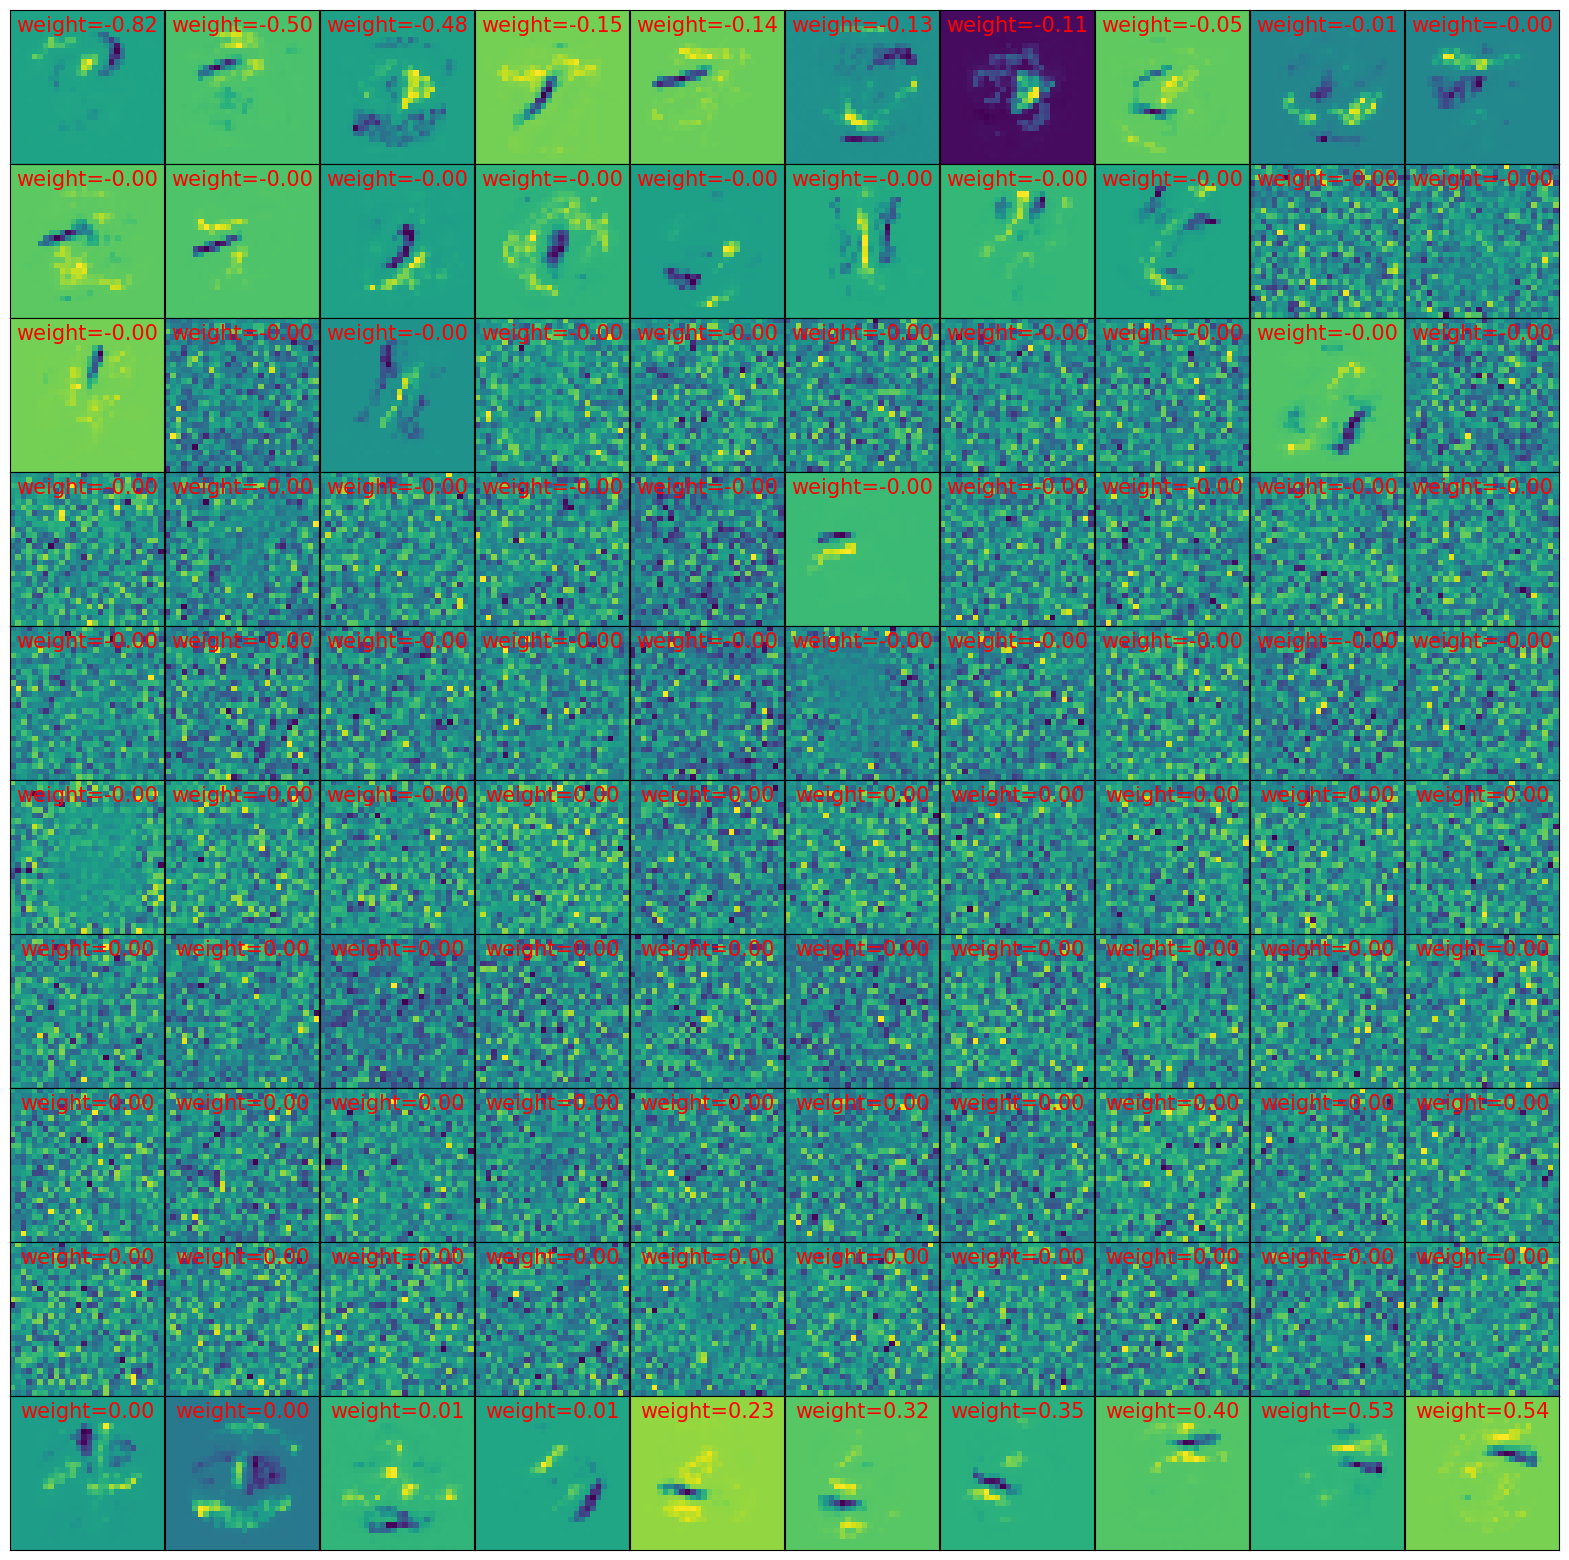

In [15]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("weight=%.2f"%(mlp.linears[1].linear.weight[im_f2,im_f1[i]]), color="red", fontsize=15,y=0.8)


plt.subplots_adjust(wspace=0, hspace=0)

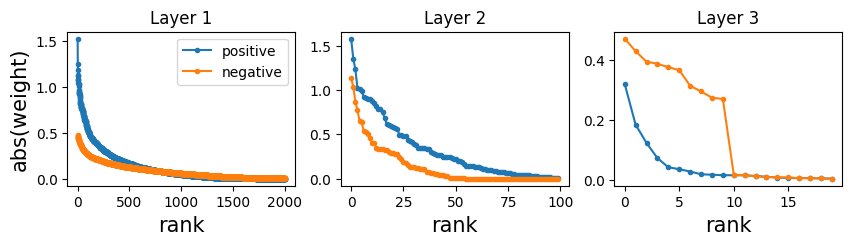

In [16]:
plt.figure(figsize=(10,2))

nums = [2000,100,20]

for i in range(3):

    plt.subplot(1,3,i+1)

    weights = mlp.linears[i].linear.weight.reshape(-1,)
    weights = weights[torch.argsort(weights)]
    plt.plot(-weights[:nums[i]].detach().numpy(), marker="o", markersize=3)
    plt.plot(weights[-nums[i]:].detach().numpy()[::-1], marker="o", markersize=3)
    plt.xlabel("rank", fontsize=15)
    if i == 0:
        plt.ylabel("abs(weight)", fontsize=15)
        plt.legend(["positive", "negative"])
    plt.title("Layer {}".format(i+1))


#plt.savefig("./fig/mnist_weights.pdf", bbox_inches="tight")